In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import optuna
import time

In [ ]:
sp_df = pd.read_csv('/content/yahoo_stock.csv',index_col='Date', parse_dates=True)

In [ ]:
sp_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [ ]:
#taking last observation of the week to reduce daily noise
sp_df = sp_df.resample('W').last()

In [ ]:
sp_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-29,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
2015-12-06,2093.840088,2051.239990,2051.239990,2091.689941,4.214910e+09,2091.689941
2015-12-13,2047.270020,2008.800049,2047.270020,2012.369995,4.301060e+09,2012.369995
2015-12-20,2040.810059,2005.329956,2040.810059,2005.550049,6.683070e+09,2005.550049
2015-12-27,2067.360107,2058.729980,2063.520020,2060.989990,1.411860e+09,2060.989990


In [ ]:
sp_df.isna().sum()

,0
High,0
Low,0
Open,0
Close,0
Volume,0
Adj Close,0


In [ ]:
#Function to create lag features and rolling stats like min, mean, max and std
def build_lagandroll(df, target, width=[2, 3]):
    for c in width:
        shifted = target.shift(c)
        df[f'lag_{c}'] = shifted
        window = target.rolling(window=c)
        dataframe = pd.concat([window.min(), window.mean(), window.max(), window.std()], axis=1)
        dataframe.columns = [f'roll{c}_min', f'roll{c}_mean', f'roll{c}_max', f'roll{c}_std']
        df = pd.concat([df, dataframe], axis=1)
    return df

In [ ]:
#Creating a df with the lag features and rolling stats as well as identify each week blocks
x = sp_df.reset_index()
x['week_block'] = x['Date'].dt.strftime('%Y%W')
target = x.pop('Close')
df = build_lagandroll(x, target, width=[1, 2, 3, 5, 7, 14])
df1 = build_lagandroll(x, target, width=[3])

In [ ]:
df.head()

,Date,High,Low,Open,Volume,Adj Close,week_block,lag_1,roll1_min,roll1_mean,...,lag_7,roll7_min,roll7_mean,roll7_max,roll7_std,lag_14,roll14_min,roll14_mean,roll14_max,roll14_std
0,2015-11-29,2093.290039,2084.129883,2088.820068,1.466840e+09,2090.110107,201547,NaN,2090.110107,2090.110107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-06,2093.840088,2051.239990,2051.239990,4.214910e+09,2091.689941,201548,2090.110107,2091.689941,2091.689941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-13,2047.270020,2008.800049,2047.270020,4.301060e+09,2012.369995,201549,2091.689941,2012.369995,2012.369995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-20,2040.810059,2005.329956,2040.810059,6.683070e+09,2005.550049,201550,2012.369995,2005.550049,2005.550049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-27,2067.360107,2058.729980,2063.520020,1.411860e+09,2060.989990,201551,2005.550049,2060.989990,2060.989990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1.head()

,Date,High,Low,Open,Volume,Adj Close,week_block,lag_1,lag_3,roll3_min,roll3_mean,roll3_max,roll3_std
0,2015-11-29,2093.290039,2084.129883,2088.820068,1.466840e+09,2090.110107,201547,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-06,2093.840088,2051.239990,2051.239990,4.214910e+09,2091.689941,201548,2090.110107,NaN,NaN,NaN,NaN,NaN
2,2015-12-13,2047.270020,2008.800049,2047.270020,4.301060e+09,2012.369995,201549,2091.689941,NaN,2012.369995,2064.723348,2091.689941,45.346214
3,2015-12-20,2040.810059,2005.329956,2040.810059,6.683070e+09,2005.550049,201550,2012.369995,2090.110107,2005.550049,2036.536662,2091.689941,47.885709
4,2015-12-27,2067.360107,2058.729980,2063.520020,1.411860e+09,2060.989990,201551,2005.550049,2091.689941,2005.550049,2026.303345,2060.989990,30.232440


In [ ]:
#Encoding the week block numerically
le = LabelEncoder()
df['week_block'] = le.fit_transform(df.week_block.astype(str))
df1['week_block'] = le.fit_transform(df1.week_block.astype(str))

In [ ]:
#Concatinate the df with target column
df = pd.concat([df, target], axis=1)
df1 = pd.concat([df1,target],axis=1)

In [ ]:
df.head()

,Date,High,Low,Open,Volume,Adj Close,week_block,lag_1,roll1_min,roll1_mean,...,roll7_min,roll7_mean,roll7_max,roll7_std,lag_14,roll14_min,roll14_mean,roll14_max,roll14_std,Close
0,2015-11-29,2093.290039,2084.129883,2088.820068,1.466840e+09,2090.110107,0,NaN,2090.110107,2090.110107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2090.110107
1,2015-12-06,2093.840088,2051.239990,2051.239990,4.214910e+09,2091.689941,1,2090.110107,2091.689941,2091.689941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2091.689941
2,2015-12-13,2047.270020,2008.800049,2047.270020,4.301060e+09,2012.369995,2,2091.689941,2012.369995,2012.369995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.369995
3,2015-12-20,2040.810059,2005.329956,2040.810059,6.683070e+09,2005.550049,3,2012.369995,2005.550049,2005.550049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005.550049
4,2015-12-27,2067.360107,2058.729980,2063.520020,1.411860e+09,2060.989990,4,2005.550049,2060.989990,2060.989990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2060.989990


In [ ]:
df1.head()

,Date,High,Low,Open,Volume,Adj Close,week_block,lag_1,lag_3,roll3_min,roll3_mean,roll3_max,roll3_std,Close
0,2015-11-29,2093.290039,2084.129883,2088.820068,1.466840e+09,2090.110107,0,NaN,NaN,NaN,NaN,NaN,NaN,2090.110107
1,2015-12-06,2093.840088,2051.239990,2051.239990,4.214910e+09,2091.689941,1,2090.110107,NaN,NaN,NaN,NaN,NaN,2091.689941
2,2015-12-13,2047.270020,2008.800049,2047.270020,4.301060e+09,2012.369995,2,2091.689941,NaN,2012.369995,2064.723348,2091.689941,45.346214,2012.369995
3,2015-12-20,2040.810059,2005.329956,2040.810059,6.683070e+09,2005.550049,3,2012.369995,2090.110107,2005.550049,2036.536662,2091.689941,47.885709,2005.550049
4,2015-12-27,2067.360107,2058.729980,2063.520020,1.411860e+09,2060.989990,4,2005.550049,2091.689941,2005.550049,2026.303345,2060.989990,30.232440,2060.989990


In [ ]:
#Splitting the data into train and validation sets
split_point = df.week_block.quantile(0.9)  # Here we are using the 90th percentile as a split point

train = df[df.week_block < split_point].copy()
y_train = train.pop('Close')
val = df[df.week_block >= split_point].copy()
y_val = val.pop('Close')

print("Train shape:", train.shape)
print("Val shape:", val.shape)

Train shape: (234, 37)
Val shape: (27, 37)


In [ ]:
split_point = df1.week_block.quantile(0.9)  # Here we are using the 90th percentile as a split point

train1 = df1[df1.week_block < split_point].copy()
y_train1 = train1.pop('Close')
val1 = df1[df1.week_block >= split_point].copy()
y_val1 = val1.pop('Close')

print("Train shape:", train.shape)
print("Val shape:", val.shape)

Train shape: (234, 37)
Val shape: (27, 37)


In [ ]:
#removing the week_block column
del train['week_block']
del val['week_block']

In [ ]:
del train1['week_block']
del val1['week_block']

In [ ]:
# Removing the 'Date' column
train = train.drop('Date', axis=1)
val = val.drop('Date', axis=1)

In [ ]:
train1 = train1.drop('Date', axis=1)
val1 = val1.drop('Date', axis=1)

In [ ]:
# Create DMatrix objects for train and test
dxtrain = xgb.DMatrix(train, label=y_train)
dxtest = xgb.DMatrix(val, label=y_val)

In [ ]:
dxtrain1 = xgb.DMatrix(train1, label=y_train1)
dxtest1 = xgb.DMatrix(val1, label=y_val1)

In [ ]:
#Creating a list of datasets to monitor while training the model to track the performance of the model
watchlist = [(dxtrain, 'train'), (dxtest, 'test')]

In [ ]:
watchlist1 = [(dxtrain1, 'train'), (dxtest1, 'test')]

In [ ]:
#Define xgBoost Parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'max_depth': 5,
    'eta': 0.01,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
}

In [ ]:
#Training the model

start_time = time.time()
num_rounds = 2000
model1 = xgb.train(xgb_params, dxtrain, num_rounds, evals=watchlist, verbose_eval=100, early_stopping_rounds=150)
end_time = time.time()

print(f"Training Time: {end_time - start_time:.2f} seconds")

[0]	train-rmse:354.99911	test-rmse:738.75346
[100]	train-rmse:141.59750	test-rmse:371.55707
[200]	train-rmse:58.03320	test-rmse:217.85228
[300]	train-rmse:24.95831	test-rmse:151.12407
[400]	train-rmse:11.52128	test-rmse:119.15978
[500]	train-rmse:6.03654	test-rmse:104.30224
[600]	train-rmse:3.60964	test-rmse:94.33098
[700]	train-rmse:2.39448	test-rmse:88.00899
[800]	train-rmse:1.68440	test-rmse:83.39848
[900]	train-rmse:1.26853	test-rmse:80.68803
[1000]	train-rmse:0.97631	test-rmse:78.59029
[1100]	train-rmse:0.79877	test-rmse:77.34637
[1200]	train-rmse:0.68656	test-rmse:76.66566
[1300]	train-rmse:0.59176	test-rmse:76.07581
[1400]	train-rmse:0.51831	test-rmse:75.63494
[1500]	train-rmse:0.45741	test-rmse:75.32262
[1600]	train-rmse:0.40080	test-rmse:75.13257
[1700]	train-rmse:0.34888	test-rmse:74.99386
[1800]	train-rmse:0.30351	test-rmse:74.93702
[1900]	train-rmse:0.25784	test-rmse:74.91960
[1999]	train-rmse:0.21826	test-rmse:74.92902
Training Time: 21.47 seconds


In [ ]:
#Training the model
start_time = time.time()
num_rounds = 2000
model2 = xgb.train(xgb_params, dxtrain1, num_rounds, evals=watchlist1, verbose_eval=100, early_stopping_rounds=150)
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

[0]	train-rmse:354.99995	test-rmse:738.75346
[100]	train-rmse:141.63283	test-rmse:371.84013
[200]	train-rmse:58.14915	test-rmse:217.85553
[300]	train-rmse:25.10535	test-rmse:150.99111
[400]	train-rmse:11.73570	test-rmse:119.29427
[500]	train-rmse:6.36073	test-rmse:104.53766
[600]	train-rmse:3.99937	test-rmse:94.73595
[700]	train-rmse:2.83641	test-rmse:88.60811
[800]	train-rmse:2.17306	test-rmse:84.01848
[900]	train-rmse:1.78309	test-rmse:81.38594
[1000]	train-rmse:1.50457	test-rmse:79.27786
[1100]	train-rmse:1.30756	test-rmse:78.01581
[1200]	train-rmse:1.16649	test-rmse:77.30033
[1300]	train-rmse:1.04226	test-rmse:76.71722
[1400]	train-rmse:0.93413	test-rmse:76.34408
[1500]	train-rmse:0.82803	test-rmse:76.07452
[1600]	train-rmse:0.72958	test-rmse:75.97794
[1700]	train-rmse:0.64057	test-rmse:75.96947
[1800]	train-rmse:0.55833	test-rmse:75.97384
[1809]	train-rmse:0.55312	test-rmse:75.97693
Training Time: 2.29 seconds


In [ ]:
#Evaluating the model
start_time = time.time()
test_preds = model1.predict(dxtest)
test_rmse = np.sqrt(mean_squared_error(y_val, test_preds))
end_time = time.time()

print("Manually calculated test RMSE:", test_rmse)

inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.2f} seconds")

Manually calculated test RMSE: 74.92901840718189
Inference Time: 0.01 seconds


In [ ]:
#Evaluating the model
start_time = time.time()
test_preds1 = model2.predict(dxtest1)
test_rmse1 = np.sqrt(mean_squared_error(y_val1, test_preds1))
end_time = time.time()
print("Manually calculated test RMSE:", test_rmse1)
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.2f} seconds")

Manually calculated test RMSE: 75.97675482183611
Inference Time: 0.01 seconds


In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 1e-3, 1.0, log= True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log= True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0 ,log=True)
    }

    dtrain = xgb.DMatrix(train, label=y_train)
    dval = xgb.DMatrix(val, label=y_val)

    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=[(dval, 'validation')],
                      early_stopping_rounds=50,
                      verbose_eval=False)

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

In [ ]:
start_time = time.time()
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
end_time = time.time()
print(f"Optimization Time: {end_time - start_time:.2f} seconds")
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-27 08:25:49,879] A new study created in memory with name: no-name-241ceae0-628e-4e90-905c-35ab5792530f
[I 2024-11-27 08:25:55,782] Trial 0 finished with value: 93.99386402988151 and parameters: {'max_depth': 10, 'eta': 0.013090160197233495, 'subsample': 0.5690532347331999, 'colsample_bytree': 0.9089451012425941, 'lambda': 4.294176196635482, 'alpha': 0.04565387004417908}. Best is trial 0 with value: 93.99386402988151.
[I 2024-11-27 08:25:59,481] Trial 1 finished with value: 76.05477597443868 and parameters: {'max_depth': 10, 'eta': 0.11234933645123152, 'subsample': 0.9950551958409173, 'colsample_bytree': 0.713492835169492, 'lambda': 3.3897845496168224, 'alpha': 2.1504337124762913}. Best is trial 1 with value: 76.05477597443868.
[I 2024-11-27 08:26:05,251] Trial 2 finished with value: 119.63804970886905 and parameters: {'max_depth': 9, 'eta': 0.005391530929294592, 'subsample': 0.5786481456279833, 'colsample_bytree': 0.7989972478839087, 'lambda': 2.2660463695415918, 'alpha': 0.

Optimization Time: 403.05 seconds
Number of finished trials: 100
Best trial:
  Value: 73.65655570454632
  Params: 
    max_depth: 8
    eta: 0.018711157319381208
    subsample: 0.6929632652849861
    colsample_bytree: 0.7000351477613095
    lambda: 0.5248461888871413
    alpha: 0.003892630119773325


In [ ]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'

dtrain = xgb.DMatrix(train, label=y_train)
dval = xgb.DMatrix(val, label=y_val)
start_time = time.time()
final_model = xgb.train(best_params, dtrain, num_boost_round=1000,
                        evals=[(dtrain, 'train'), (dval, 'validation')],
                        verbose_eval=100, early_stopping_rounds=150)
end_time = time.time()
print(f"Training Best Param Time: {end_time - start_time:.2f} seconds")

start_time1 = time.time()
xgb_pred = final_model.predict(dval)
end_time1 = time.time()
print(f"Inference Best Param Time: {end_time1 - start_time1:.2f} seconds")

# Calculating the RMSE value
rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f'Final model RMSE: {rmse}')

[0]	train-rmse:352.00650	validation-rmse:733.44410
[100]	train-rmse:60.13511	validation-rmse:214.51539
[200]	train-rmse:11.35850	validation-rmse:114.83577
[300]	train-rmse:2.99237	validation-rmse:89.05338
[400]	train-rmse:1.10088	validation-rmse:79.41566
[500]	train-rmse:0.54401	validation-rmse:76.23682
[600]	train-rmse:0.30166	validation-rmse:74.88213
[700]	train-rmse:0.17823	validation-rmse:74.25000
[800]	train-rmse:0.11182	validation-rmse:73.89291
[900]	train-rmse:0.06968	validation-rmse:73.73813
[999]	train-rmse:0.04175	validation-rmse:73.65656
Training Best Param Time: 4.77 seconds
Inference Best Param Time: 0.00 seconds
Final model RMSE: 73.65655570454632


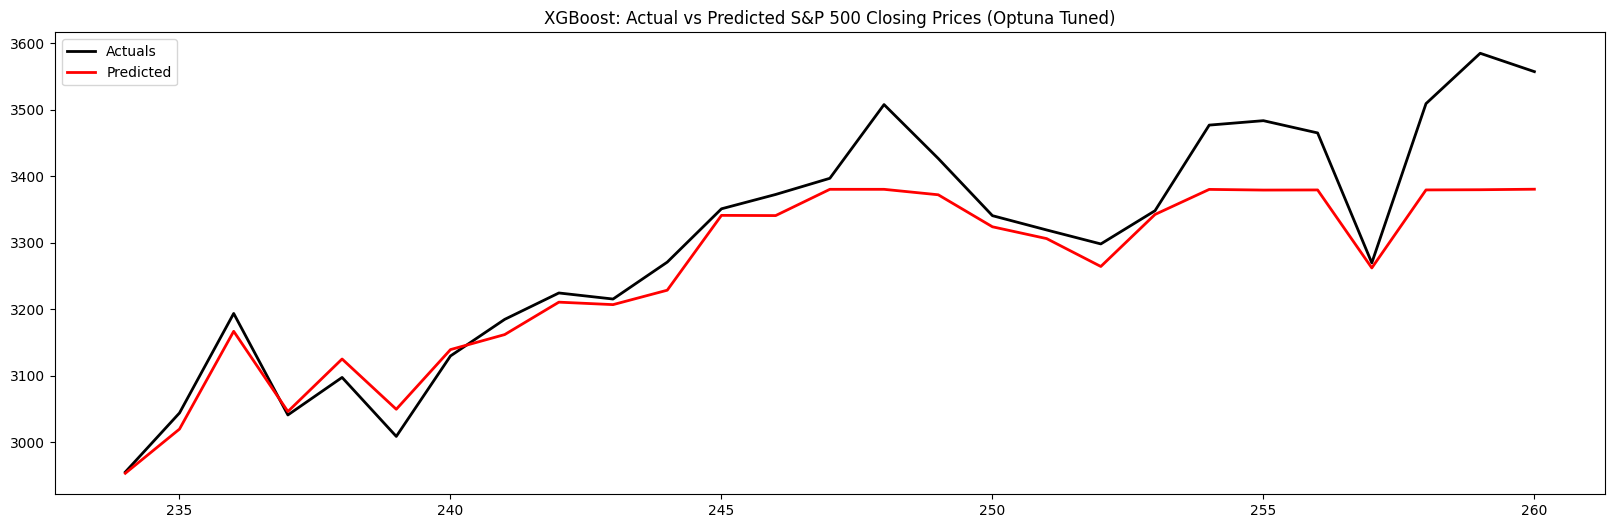

In [ ]:
#Visualizing the values
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(val.index, y_val, 'k', label='Actuals', linewidth=2)
plt.plot(val.index, xgb_pred, 'r', label='Predicted', linewidth=2)
plt.legend()
plt.title('XGBoost: Actual vs Predicted S&P 500 Closing Prices (Optuna Tuned)')
plt.show()

In [ ]:
def objective1(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 1e-3, 1.0, log= True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log= True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0 ,log=True)
    }

    dtrain1 = xgb.DMatrix(train1, label=y_train1)
    dval1 = xgb.DMatrix(val1, label=y_val1)

    model = xgb.train(params, dtrain1, num_boost_round=1000,
                      evals=[(dval1, 'validation')],
                      early_stopping_rounds=50,
                      verbose_eval=False)
    preds = model.predict(dval1)
    rmse = np.sqrt(mean_squared_error(y_val1, preds))
    return rmse

In [ ]:
start_time = time.time()
study = optuna.create_study(direction='minimize')
study.optimize(objective1, n_trials=100)
end_time = time.time()

print(f"Optimization Time: {end_time - start_time:.2f} seconds")
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-27 08:32:38,124] A new study created in memory with name: no-name-72f2a8bf-454f-4a43-b9a5-59359e95c52e
[I 2024-11-27 08:32:38,341] Trial 0 finished with value: 75.4547314689094 and parameters: {'max_depth': 9, 'eta': 0.5337294664003394, 'subsample': 0.524018131026678, 'colsample_bytree': 0.9978049538560705, 'lambda': 0.09931223002928283, 'alpha': 0.0032800111208168645}. Best is trial 0 with value: 75.4547314689094.
[I 2024-11-27 08:32:39,249] Trial 1 finished with value: 76.64996595966302 and parameters: {'max_depth': 4, 'eta': 0.006000683435688937, 'subsample': 0.9569840401006362, 'colsample_bytree': 0.5506185339411547, 'lambda': 0.0031050399531645225, 'alpha': 0.02567471958080279}. Best is trial 0 with value: 75.4547314689094.
[I 2024-11-27 08:32:41,179] Trial 2 finished with value: 74.58676124018932 and parameters: {'max_depth': 9, 'eta': 0.012441600043449012, 'subsample': 0.9813998635908813, 'colsample_bytree': 0.9640225664412738, 'lambda': 0.3665580948883093, 'alpha': 0

Optimization Time: 154.91 seconds
Number of finished trials: 100
Best trial:
  Value: 74.07363534839885
  Params: 
    max_depth: 7
    eta: 0.03657791130669493
    subsample: 0.9410701012407948
    colsample_bytree: 0.8051994557819512
    lambda: 0.7298376211165978
    alpha: 0.03965160846560994


In [ ]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'

dtrain1 = xgb.DMatrix(train1, label=y_train1)
dval1 = xgb.DMatrix(val1, label=y_val1)

start_time = time.time()

final_model1 = xgb.train(best_params, dtrain1, num_boost_round=1000,
                        evals=[(dtrain1, 'train'), (dval1, 'validation')],
                        verbose_eval=100, early_stopping_rounds=150)
end_time = time.time()
print(f"Training Best Param Time: {end_time - start_time:.2f} seconds")

start_time1 = time.time()
xgb_pred1 = final_model1.predict(dval1)
end_time1 = time.time()

print(f"Inference Best Param Time: {end_time1 - start_time1:.2f} seconds")
# Calculating the RMSE value
rmse1 = np.sqrt(mean_squared_error(y_val1, xgb_pred1))
print(f'Final model RMSE: {rmse1}')

[0]	train-rmse:345.82010	validation-rmse:722.88827
[100]	train-rmse:11.62910	validation-rmse:115.56202
[200]	train-rmse:0.93674	validation-rmse:78.83712
[300]	train-rmse:0.19875	validation-rmse:74.66014
[400]	train-rmse:0.09760	validation-rmse:74.10234
[500]	train-rmse:0.04543	validation-rmse:74.07509
[600]	train-rmse:0.02408	validation-rmse:74.07385
[700]	train-rmse:0.01433	validation-rmse:74.07373
[773]	train-rmse:0.01117	validation-rmse:74.07378
Training Best Param Time: 1.61 seconds
Inference Best Param Time: 0.00 seconds
Final model RMSE: 74.07377282664736


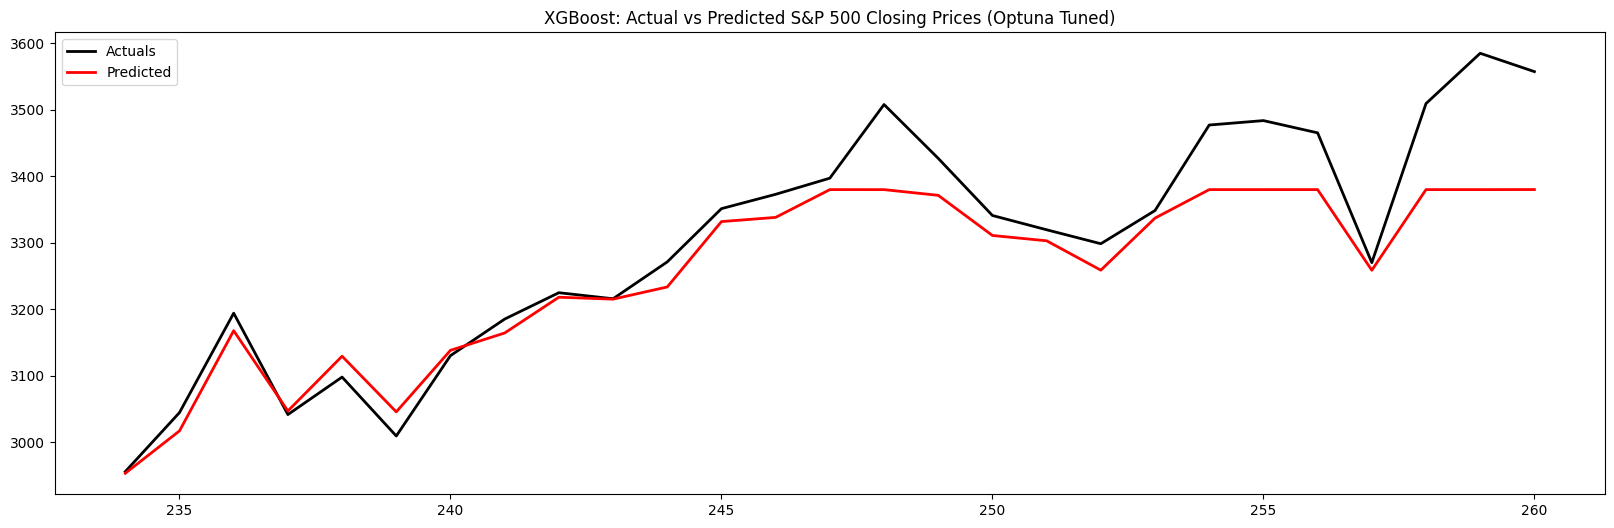

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(val.index, y_val1, 'k', label='Actuals', linewidth=2)
plt.plot(val.index, xgb_pred1, 'r', label='Predicted', linewidth=2)
plt.legend()
plt.title('XGBoost: Actual vs Predicted S&P 500 Closing Prices (Optuna Tuned)')
plt.show()

## Using a 60 day window

In [ ]:
#Preparing a 60 day sequences
def prepare_sequences(data, sequence_length=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']].values)

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length, 3])

    return np.array(X), np.array(y), scaler

X, y, scaler = prepare_sequences(sp_df)

In [ ]:
#Splitting data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
#Reshaping X to make it sutable for the xGBoost model
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [ ]:
#Define optuna case study
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log = True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_2d, y_train)
    preds = model.predict(X_test_2d)
    mse = mean_squared_error(y_test, preds)
    return mse


In [ ]:
#Perform hyper parameter tuning
study = optuna.create_study(direction='minimize')

start_time = time.time()
study.optimize(objective, n_trials=100)
end_time = time.time()
print(f"Optimization Time: {end_time - start_time:.2f} seconds")
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-12-04 16:18:12,833] A new study created in memory with name: no-name-a8b56e36-4fae-4830-9158-0c82678c7d17
[I 2024-12-04 16:18:26,620] Trial 0 finished with value: 0.012462660449249307 and parameters: {'max_depth': 8, 'learning_rate': 0.0991007786497286, 'n_estimators': 315, 'min_child_weight': 1, 'subsample': 0.8485546442337595, 'colsample_bytree': 0.6410297153691181}. Best is trial 0 with value: 0.012462660449249307.
[I 2024-12-04 16:19:26,693] Trial 1 finished with value: 0.012036527007946675 and parameters: {'max_depth': 9, 'learning_rate': 0.026303619834581373, 'n_estimators': 825, 'min_child_weight': 4, 'subsample': 0.7812199097346952, 'colsample_bytree': 0.9066599066140062}. Best is trial 1 with value: 0.012036527007946675.
[I 2024-12-04 16:19:30,855] Trial 2 finished with value: 0.015311865812977632 and parameters: {'max_depth': 4, 'learning_rate': 0.6079736381776935, 'n_estimators': 602, 'min_child_weight': 9, 'subsample': 0.8387159554304197, 'colsample_bytree': 0.58667

Optimization Time: 727.33 seconds
Number of finished trials: 100
Best trial:
  Value: 0.011358177333994997
  Params: 
    max_depth: 1
    learning_rate: 0.11855519865971538
    n_estimators: 1000
    min_child_weight: 6
    subsample: 0.9225979658511201
    colsample_bytree: 0.5897331266613975


In [ ]:
# Get the best parameters
best_params = study.best_params

# Train the final model with the best parameters
final_model = xgb.XGBRegressor(**best_params)

start_time = time.time()
final_model.fit(X_train_2d, y_train)
end_time = time.time()

print(f"Training Best Param Time: {end_time - start_time:.2f} seconds")

Training Best Param Time: 4.61 seconds


In [ ]:
# Make predictions using the best model
start_time1 = time.time()
predictions = final_model.predict(X_test_2d)
end_time1 = time.time()
print(f"Inference Best Param Time: {end_time1 - start_time1:.2f} seconds")


Inference Best Param Time: 0.00 seconds


In [ ]:
# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(np.column_stack((np.zeros((len(predictions), 3)), predictions, np.zeros((len(predictions), 1)))))[:, 3]
actual_values = scaler.inverse_transform(np.column_stack((np.zeros((len(y_test), 3)), y_test.reshape(-1, 1), np.zeros((len(y_test), 1)))))[:, 3]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
print(f"Root Mean Square Error: {rmse}")


Root Mean Square Error: 191.6032780789489


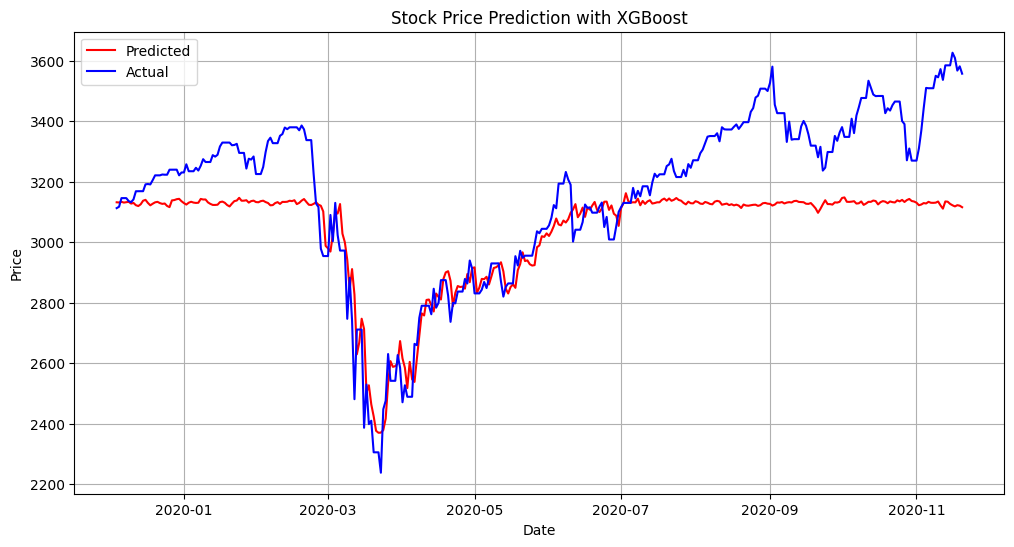

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sp_df.index[-len(predictions):], predictions, label='Predicted', color='red')
plt.plot(sp_df.index[-len(predictions):], actual_values, label='Actual', color='blue')
plt.title('Stock Price Prediction with XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()